In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from utils import write_log, get_device, process_data, get_metrics
from train import fit, evaluate
import CNN, DNN, MLP
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns

## We work on the 2D dataset with size 28x28

In [2]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)

write_log('train_dataset_log.txt', str(train_dataset))
write_log('test_dataset_log.txt', str(test_dataset))
write_log('validation_dataset_log.txt', str(validation_dataset))

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


torch.Size([11959, 2352]) torch.Size([11959])
Epoch [1/20], Loss: 143.9528
Epoch [2/20], Loss: 94.5022
Epoch [3/20], Loss: 86.3033
Epoch [4/20], Loss: 81.0016
Epoch [5/20], Loss: 77.1666
Epoch [6/20], Loss: 73.0091
Epoch [7/20], Loss: 70.4463
Epoch [8/20], Loss: 67.3105
Epoch [9/20], Loss: 65.1176
Epoch [10/20], Loss: 63.6629
Epoch [11/20], Loss: 61.7806
Epoch [12/20], Loss: 60.8163
Epoch [13/20], Loss: 59.7350
Epoch [14/20], Loss: 57.5951
Epoch [15/20], Loss: 56.1686
Epoch [16/20], Loss: 55.4309
Epoch [17/20], Loss: 54.0144
Epoch [18/20], Loss: 54.5913
Epoch [19/20], Loss: 54.5675
Epoch [20/20], Loss: 51.9961
[0.58362989 0.93833333 0.91324201 0.58146487 0.66984127 0.71895425
 0.86543909 0.9748954 ] [0.67213115 0.90224359 0.64308682 0.67184801 0.86831276 0.38732394
 0.91741742 0.99148936] [0.9631728  0.98677154 0.99389068 0.90147783 0.96727502 0.98629264
 0.96551724 0.99593358]


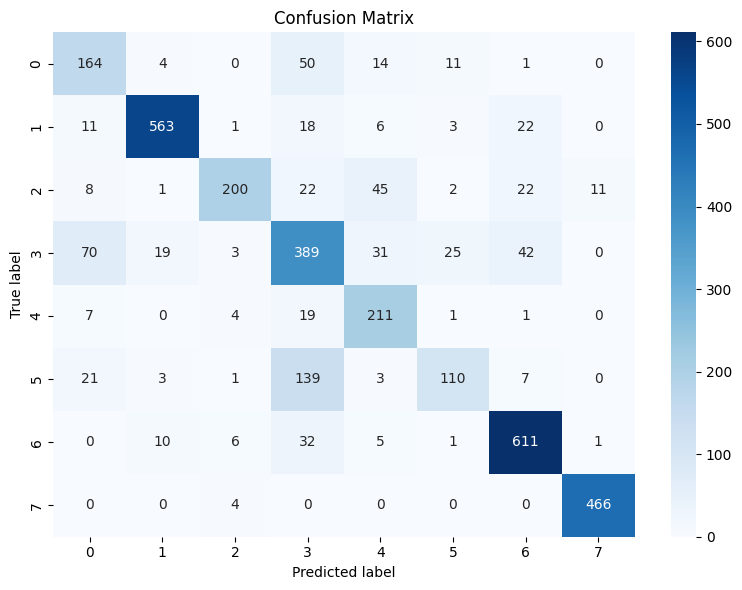

In [ ]:
# variables declaration
model_type = 'MLNN'
n_epochs = 20
n_layers = 1
n_inputs = n_channels * 28 * 28
size_hidden_layer = (n_inputs + n_classes) // 2 # n_classes = n_outputs
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001


device = get_device()

assert device is not None

write_log('main_log.txt', f'Using device: {device}\n')

assert model_type is not None

if model_type == 'CNN':
    model = CNN.CNN(n_channels, n_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    X, y = process_data(train_loader, flag=False)
    loss_values_training, trained_model = fit(device, X, y, model, loss_function, optimizer, n_epochs, batch_size=BATCH_SIZE)
    write_log('loss_values_training.txt', str(loss_values_training))

    # evaluate data
    X, y = process_data(validation_loader, flag=False)
    CM_val, f1_val = evaluate(device, X, y, trained_model, batch_size=BATCH_SIZE)
    write_log('validation_results.txt', f'Confusion Matrix:\n{CM_val}\nF1 Score: {f1_val}\n')


    # test data
    X, y = process_data(test_loader, flag=False)
    CM, f1 = evaluate(device, X, y, trained_model, batch_size=BATCH_SIZE)
    write_log('results.txt', f'Confusion Matrix:\n{CM}\nF1 Score: {f1}\n')

    # Plot the CM
    plt.figure(figsize=(8, 6))
    sns.heatmap(CM, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in range(n_classes)],
                yticklabels=[str(i) for i in range(n_classes)]) 
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    precision, sensivity, specificity = get_metrics(CM)
    print(precision, sensivity, specificity)


elif model_type == 'MLNN':
    model = MLP.MLP(n_inputs, [size_hidden_layer] * n_layers, n_classes, 0.2)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # train loader is an array of tuples (X, y) where X is a batch of images and y are the corresponding labels
    # extract X and y
    # train data    
    X, y = process_data(train_loader)
    print(X.shape, y.shape) 
    write_log("main_log.txt", f"Processed training data shapes: X: {X.shape}, y: {y.shape}\n")
    loss_values_training, trained_model = fit(device, X, y, model, loss_function, optimizer, n_epochs, batch_size=BATCH_SIZE)
    write_log('loss_values_training.txt', str(loss_values_training))
    
    # evaluate data
    X, y = process_data(validation_loader)
    CM_val, f1_val = evaluate(device, X, y, trained_model)
    write_log('validation_results.txt', f'Confusion Matrix:\n{CM_val}\nF1 Score: {f1_val}\n')



    # test data
    X, y = process_data(test_loader) 
    CM, f1 = evaluate(device, X, y, trained_model)
    write_log('results.txt', f'Confusion Matrix:\n{CM}\nF1 Score: {f1}\n')

    # Plot the CM
    plt.figure(figsize=(8, 6))
    sns.heatmap(CM, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in range(n_classes)],
                yticklabels=[str(i) for i in range(n_classes)]) 
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    precision, sensivity, specificity = get_metrics(CM)
    print(precision, sensivity, specificity)




else:
    # model = MLP.MLP()
    pass



